- As project 2, I made functions at .py file, and then ,plot results in .ipynb file. 
- I condider Repeated First Price Auction(hereinafter called repeated FPA), not second price auction.
- Players in Repeated FPA must have algorithm whose regret coverges to 0. 

# Project 3: Repeated First Price Auction

## Information Setting

- Full Information: Each player knows their own value (v) which is fixed across all rounds
- Full Feedback: After each round, each player observes all bids from all players, not just their own outcome

This setting allows players to use opponent's bid history directly in their learning algorithms.

## Parameters

- n_rounds: 1000 - number of rounds per simulation
- k: 100 - number of discrete arms (discretization level)
- n_mc: 100 - number of Monte Carlo simulation runs
- h: scaling parameter (default: value) - used in Exponential Weight algorithms
- value (v): 10.0 - player's value for the item (default)
- learning_rate: sqrt(log(k) / n) - learning rate for Exponential Weight algorithms (default for flexible)
  Optimal learning rate: epsilon = sqrt(log(k) / T)
  Note: cumulative_payoffs are normalized by h, so epsilon does not need h factor
- delta: 0.95 - discount factor for long-term algorithm (default)
- observation_rounds: 20 - number of observation rounds for exploitation algorithm (default)

## Algorithms

1. 1_empirical: Empirical algorithm - maximizes current round expected utility
3. 3_flexible: Flexible algorithm - Exponential Weight with learning_rate = np.sqrt(np.log(k) / n) (default, optimal)
6. 6_Exploitation: Exploitation algorithm - waits and exploits when opponent bids low

In [1]:
import sys, importlib
from pathlib import Path
sys.path.insert(0, str(Path('algorithm').resolve()))

empirical, ew, exploitation = [importlib.import_module(m) for m in ['1_empirical', '2_ew', '3_exploitation']]

import repeated_FPA
from repeated_FPA import run_repeated_fpa, plot_part1_results

# Part 1
- we simulate the game with players who use above algorithms (This is Part1). 

In [4]:
# Part 1 Implementation

# Parameters
n_rounds = 1000
k = 50
n_mc = 100

MC iteration 10/100 completed
MC iteration 20/100 completed
MC iteration 30/100 completed
MC iteration 40/100 completed
MC iteration 50/100 completed
MC iteration 60/100 completed
MC iteration 70/100 completed
MC iteration 80/100 completed
MC iteration 90/100 completed
MC iteration 100/100 completed
Completed: empirical vs EW
Figure saved to: ../figures/empirical_vs_ew.png


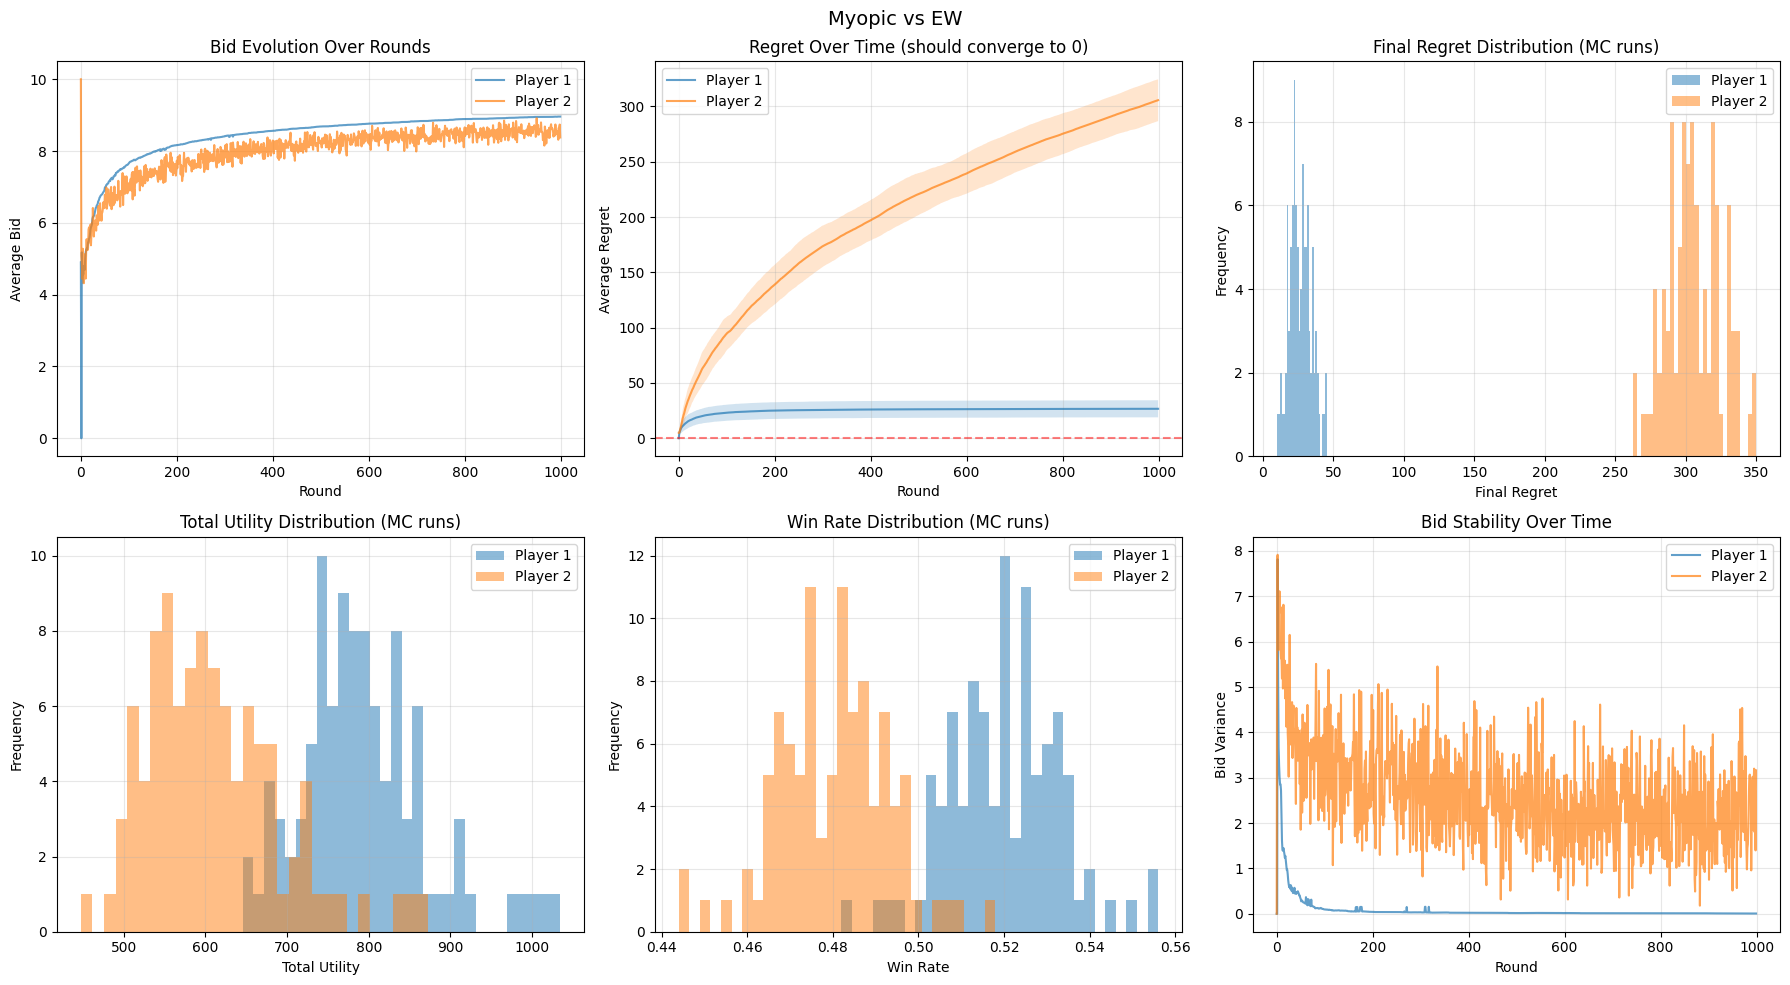


=== Summary Statistics ===
Player 1:
  Mean Regret: 26.65 ± 7.72
  Mean Utility: 793.18 ± 76.81
  Mean Win Rate: 0.520 ± 0.013

Player 2:
  Mean Regret: 305.67 ± 18.90
  Mean Utility: 609.64 ± 80.62
  Mean Win Rate: 0.480 ± 0.013
Summary statistics saved to: ../data/empirical_vs_ew_summary.csv
Detailed results saved to: ../data/empirical_vs_ew_detailed.csv
Regret history saved to: ../data/empirical_vs_ew_regret_history.csv
Bid history saved to: ../data/empirical_vs_ew_bid_history.csv


In [5]:
# Example 1: Empirical vs EW
# Note: ew_algorithm uses optimal learning_rate = sqrt(log(k) / n) by default
# Optimal learning rate: epsilon = sqrt(log(k) / T)

v1, v2 = 10.0, 10.0
player1 = (empirical.empirical_algorithm, v1, {'k': k, 'h': v1})
player2 = (ew.flexible_algorithm, v2, {'k': k, 'h': v2, 'learning_rate': None})  # None = default (sqrt(log(k) / n)), or specify a value like 0.1
results_empirical_vs_ew = run_repeated_fpa(player1, player2, n_rounds, n_mc, k=k)
print("Completed: Empirical vs EW")
plot_part1_results(results_empirical_vs_ew, title="Empirical vs EW")

In [ ]:
v1, v2 = 10.0, 10.0
player1 = (ew.flexible_algorithm, v1, {'k': k, 'h': v1, 'learning_rate': 100})
player2 = (ew.flexible_algorithm, v2, {'k': k, 'h': v2, 'learning_rate': None})
results_FTL_vs_ew = run_repeated_fpa(player1, player2, n_rounds, n_mc, k=k)
print("Completed: FTL vs EW")
plot_part1_results(results_FTL_vs_ew, title="FTL vs EW")

MC iteration 10/100 completed


In [ ]:
v1, v2 = 10.0, 10.0
player1 = (ew.flexible_algorithm, v1, {'k': k, 'h': v1, 'learning_rate': 0.1})
player2 = (ew.flexible_algorithm, v2, {'k': k, 'h': v2, 'learning_rate': None})
results_uniform_vs_ew = run_repeated_fpa(player1, player2, n_rounds, n_mc, k=k)
print("Completed: Uniform guessing vs EW")
plot_part1_results(results_uniform_vs_ew, title="Uniform guessing vs EW")

what if they have different value?

What if we mix the type of players, and then see the result? Will it converge to Nash Equilibrium?

# Part 2
- Exploitation strategy vs 1_empirical (Empirical strategy)
- Exploitation strategy vs 2_ew (Exponential Weight algorithm)

In [10]:
# Part 2 Implementation

# Parameters
n_rounds = 100  # number of rounds
k = 100  # number of arms (discretization)
n_mc = 1  # number of Monte Carlo simulations

Completed: Flexible vs Exploitation
Figure saved to: ../figures/flexible_vs_exploitation_(part_2).png


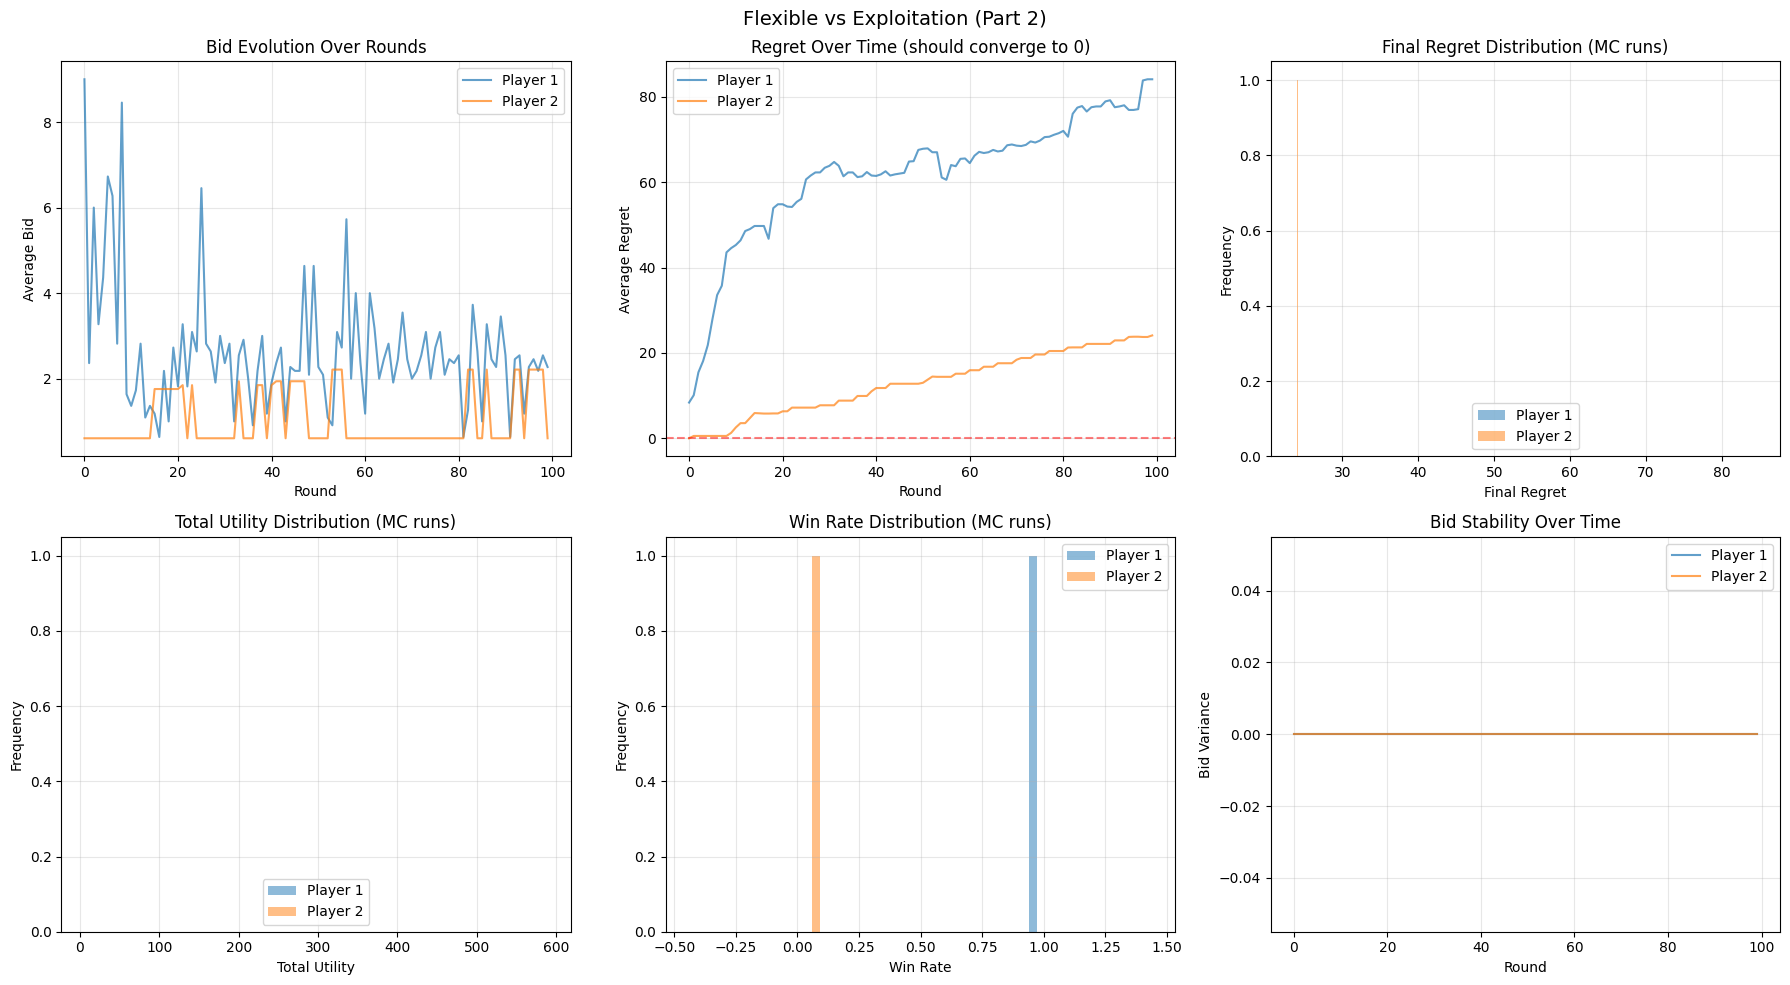


=== Summary Statistics ===
Player 1:
  Mean Regret: 84.09 ± 0.00
  Mean Utility: 588.64 ± 0.00
  Mean Win Rate: 0.940 ± 0.000

Player 2:
  Mean Regret: 24.09 ± 0.00
  Mean Utility: 6.09 ± 0.00
  Mean Win Rate: 0.060 ± 0.000


In [ ]:
v1, v2 = 9.0, 3.0
# Use default learning rate (sqrt(log(k) / n)) - no need to specify explicitly
player1 = (ew.flexible_algorithm, v1, {'k': k, 'h': v1, 'learning_rate': None})  # None = default (sqrt(log(k) / n)), or specify a value)
player2 = (exploitation.exploitation_algorithm, v2, {'k': k, 'h': v2, 'observation_rounds': 5})
results_ew_vs_exploitation = run_repeated_fpa(player1, player2, n_rounds, n_mc, k=k)
print("Completed: EW vs Exploitation")
plot_part1_results(results_ew_vs_exploitation, title="EW vs Exploitation (Part 2)")